# Prédiction de churn dans les télécoms

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Importer les librairies
import os
import optuna
import yaml
import pickle
import pandas as pd
import numpy as np
import sklearn
from functools import partial
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from ml.utils import (loader, 
                      splitter, 
                      formater, 
                      nan_replacer, 
                      encoder, 
                      preprocessor, 
                      custom_cross_val_score, 
                      objective)

In [3]:
a = np.array([1])
np.isnan(a)

array([False])

In [4]:
# Paramètres
config_path = "/Users/bguedou/churner-ml/config.yaml"

In [5]:
with open(config_path, 'r') as file:
    config = yaml.safe_load(file)

In [6]:
# Charger le jeu de données
df = loader(config['data']['datapath'])
print("Le jeu de données a {} lignes et {} colonnes ou variables.".format(*df.shape))
print("\n")
print("Les colonnes du jeu de données sont: \n\n", ", ".join(df.columns))

Le jeu de données a 7043 lignes et 21 colonnes ou variables.


Les colonnes du jeu de données sont: 

 customerID, gender, SeniorCitizen, Partner, Dependents, tenure, PhoneService, MultipleLines, InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies, Contract, PaperlessBilling, PaymentMethod, MonthlyCharges, TotalCharges, Churn


In [7]:
df.head(2)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No


In [8]:
# Séparer le jeu d'entrainement, le jeu de validation et le jeu de test

df_train, df_test = splitter(df,
                             config['data']['categorical'],
                             config['data']['numerical'], 
                             config['data']['label'],
                             seed=42,
                             percentage=0.3)

df_test, df_cal = splitter(df_test,
                             config['data']['categorical'],
                             config['data']['numerical'], 
                             config['data']['label'],
                             seed=42,
                             percentage=0.5)

df_train_base = df_train.copy()

In [9]:
df_train.shape

(4930, 20)

In [10]:
df_test.shape

(1056, 20)

In [11]:
# Remplacement des valeurs symbols par nan
df_train = nan_replacer(df_train, list_variables=config['data']['numerical'], list_symbols=[" "])
# Conversion des variables numériques au bon format
df_train = formater(df_train, list_variables=config['data']['numerical'], new_type='float32')
# Conversion des variables catégorielles au bon format
df_train = formater(df_train, list_variables=config['data']['categorical'], new_type='object')

#### 1 - Echelle des variables numériques

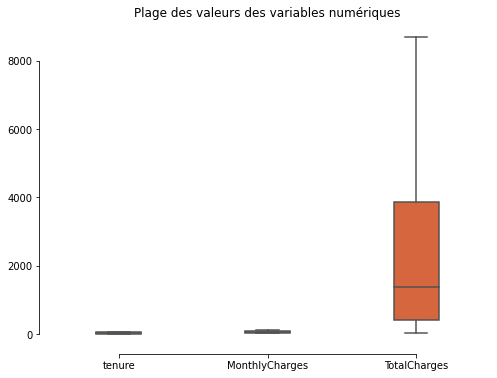

In [12]:
plt.figure(figsize=(8, 6))
plt.title("Plage des valeurs des variables numériques")
graph = sns.boxplot(data=df_train[config['data']['numerical']],  width=0.3, palette=["#FFC312", "#F79F1F", "#EE5A24"]);
sns.despine(offset=5, trim=True)
plt.show()

<div style="color: blue"> Conclusion: <div/>
<p style="color: black"> Le graphique nous montre que TotalCharges a une plus grande amplitude de valeurs que les autres variables numériques. Ce qui montre la nécessité de normaliser les variables numériques pour les mettre à la même échelle en fonction de l'algorithme choisi. </p>

#### 2 - Doublons et valeurs manquantes

In [13]:
# Suppression des doublons
df_train.drop_duplicates(inplace=True)

In [14]:
df_train.shape

(4921, 20)

In [15]:
# Valeurs manquantes
values = (100 * df_train.isnull().sum() / df_train.shape[0]).values
filter_ = values > 0
var_names = (100 * df_train.isnull().sum()/df_train.shape[0]).index
var_names = var_names[filter_]
values = values[filter_]

for (var, val) in zip(var_names.tolist(), values):
    print("- Pour la variable {} le pourcentage de valeurs manquantes est: {} %".format(var, round(val, 3)))

- Pour la variable TotalCharges le pourcentage de valeurs manquantes est: 0.142 %


<div style="color: blue"> Conclusion: <div/>
<p style="color: black"> La seule variable ayant des données manquantes est TotalCharges. Nous décidons donc de l'imputer par la valeur médiane </p>

#### 3 - Analyses univariées

In [16]:
# Variables numériques
df_train[config['data']['numerical']].describe()

,tenure,MonthlyCharges,TotalCharges
count,4921.000000,4921.000000,4914.000000
mean,32.528755,64.996788,2309.219971
std,24.632065,30.236048,2292.595947
min,0.000000,18.400000,18.850000
25%,9.000000,35.599998,402.662506
50%,29.000000,70.599998,1391.000000
75%,56.000000,90.050003,3865.562500
max,72.000000,118.750000,8684.799805


In [17]:
# Vraibales catégorielles
df_train[config['data']['categorical']].describe()

,gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod
count,4921,4921,4921,4921,4921,4921,4921,4921,4921,4921,4921,4921,4921,4921,4921,4921
unique,2,2,2,2,2,3,3,3,3,3,3,3,3,3,2,4
top,Male,0,No,No,Yes,No,Fiber optic,No,No,No,No,Yes,Yes,Month-to-month,Yes,Electronic check
freq,2472,4127,2549,3454,4425,2338,2174,2435,2138,2136,2407,1941,1931,2695,2915,1651


#### 4 - Analyse bi-variée avec la variable cible

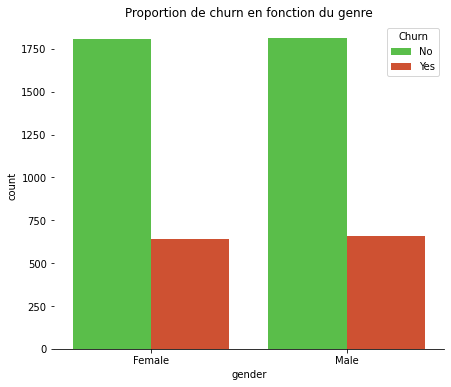

In [18]:
# Genre et Churn
plt.figure(figsize=(7, 6))
plt.title("Proportion de churn en fonction du genre" )
ax = sns.countplot(x="gender", hue="Churn", data=df_train, palette=["#4cd137","#e84118"])
sns.despine(left=True)
plt.show()

<div style="color: blue"> Conclusion: <div/>
<p style="color: black"> L'attrition du client ne semble pas dépendre de son genre. Nous pouvons le confirmer avec un test du chi2 et supprimer la variable genre au besoin.</p>

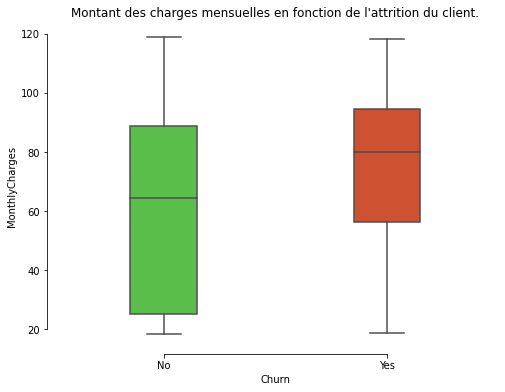

In [19]:
# MonthlyCharges et Churn

plt.figure(figsize=(8, 6))
plt.title("Montant des charges mensuelles en fonction de l'attrition du client.")
graph = sns.boxplot(data=df_train, x="Churn", y=df_train['MonthlyCharges'],  width=0.3, palette=["#4cd137","#e84118"]);
sns.despine(offset=5, trim=True)
plt.show()

<div style="color: blue"> Conclusion: <div/>
<p style="color: black"> Il semblerait que plus le montant de charges mensuelles augmentes plus le client a de chances de quitter l'entreprise.</p>

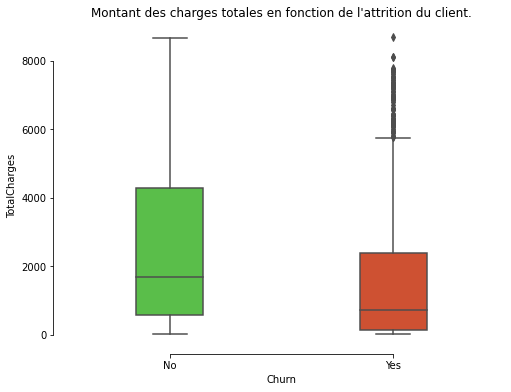

In [20]:
# TotalCharges et Churn

plt.figure(figsize=(8, 6))
plt.title("Montant des charges totales en fonction de l'attrition du client.")
graph = sns.boxplot(data=df_train, x="Churn", y=df_train['TotalCharges'],  width=0.3, palette=["#4cd137","#e84118"]);
sns.despine(offset=5, trim=True)
plt.show()

<div style="color: blue"> Conclusion: <div/>
<p style="color: black">Les clients qui quittent l'entreprise, semblent avoir des montants de charges totales plus bas.</p>

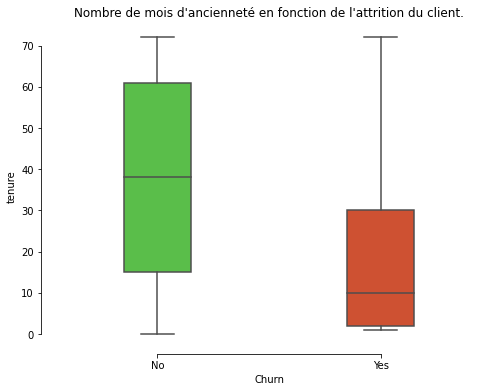

In [21]:
# Tenure et Churn

plt.figure(figsize=(8, 6))
plt.title("Nombre de mois d'ancienneté en fonction de l'attrition du client.")
graph = sns.boxplot(data=df_train, x="Churn", y=df_train['tenure'],  width=0.3, palette=["#4cd137","#e84118"]);
sns.despine(offset=5, trim=True)
plt.show()

<div style="color: blue"> Conclusion: <div/>
<p style="color: black">Les clients les plus anciens semblent les plus fidèles que les nouveaux  .</p>

#### 5 - Modélisation

In [22]:
%%time

# Pré-traitements sur le jeu d'entraînement 
X, y = preprocessor(df_train_base, config, option_train=None, option_output=None)

======= L'encodage des variables catégorielles est terminée ! =======
CPU times: user 45.9 ms, sys: 4.89 ms, total: 50.8 ms
Wall time: 61.4 ms


A - Arbre de décision

In [23]:
%%time
# Définition des passes de la cross-validation
skf = StratifiedKFold(n_splits=config['model']['k'], 
                      random_state=config['seed'], 
                      shuffle=True).split(df_train, 
                                          df_train[config['data']['label']]
                                         )

scores = []
for train_idx, val_idx in skf:
    # Définition du jeu d'entrainement et de validation
    # pour la passe courante
    X_train = X[train_idx]
    y_train = y[train_idx]
    X_val = X[val_idx]
    y_val = y[val_idx]
    # Calcul de la median de la colonne TotalCharges
    var_names = config['data']['categorical']+config['data']['numerical']
    id_ToCh = var_names.index('TotalCharges')
    median = np.nanmedian(X_train[:, id_ToCh])
    col_values = X_train[:, id_ToCh]
    col_values[np.isnan(col_values)] = median
    X_train[:, id_ToCh] = col_values
    # Instanciation
    tree_clf = DecisionTreeClassifier(random_state=config['seed'])
    # Entrainement
    tree_clf.fit(X_train, y_train)
    # Prediction
    col_values = X_val[:, id_ToCh]
    col_values[np.isnan(col_values)] = median
    X_val[:, id_ToCh] = col_values
    y_val_pred = tree_clf.predict(X_val)
    # Métrique ou performance
    score = sklearn.metrics.roc_auc_score(y_val, y_val_pred)
    scores.append(score)

print("La performance de notre classifcation sur le jeu de validation est de {} %.".format(round(np.mean(scores)*100, 3)))


ValueError: Input X contains NaN.
DecisionTreeClassifier does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

B - Forêt aléatoire

In [24]:
%%time
# Définition des passes de la cross-validation
skf = StratifiedKFold(n_splits=config['model']['k'], 
                      random_state=config['seed'], 
                      shuffle=True).split(df_train, 
                                          df_train[config['data']['label']]
                                         )

scores = []
for train_idx, val_idx in skf:
    # Définition du jeu d'entrainement et de validation
    # pour la passe courante
    X_train = X[train_idx]
    y_train = y[train_idx]
    X_val = X[val_idx]
    y_val = y[val_idx]
    # Calcul de la median de la colonne TotalCharges
    var_names = config['data']['categorical']+config['data']['numerical']
    id_ToCh = var_names.index('TotalCharges')
    median = np.nanmedian(X_train[:, id_ToCh])
    col_values = X_train[:, id_ToCh]
    col_values[np.isnan(col_values)] = median
    X_train[:, id_ToCh] = col_values
    # Instanciation
    rf_clf = RandomForestClassifier(random_state=config['seed'])
    # Entrainement
    rf_clf.fit(X_train, y_train)
    # Prediction
    col_values = X_val[:, id_ToCh]
    col_values[np.isnan(col_values)] = median
    X_val[:, id_ToCh] = col_values
    y_val_pred = rf_clf.predict(X_val)
    # Métrique ou performance
    score = sklearn.metrics.roc_auc_score(y_val, y_val_pred)
    scores.append(score)

print("La performance de notre classifcation sur le jeu de validation est de {} %.".format(round(np.mean(scores)*100, 3)))

ValueError: Input X contains NaN.
RandomForestClassifier does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

C - Gradient Boosting 

In [25]:
%%time
# Définition des passes de la cross-validation
skf = StratifiedKFold(n_splits=config['model']['k'], 
                      random_state=config['seed'], 
                      shuffle=True).split(df_train, 
                                          df_train[config['data']['label']]
                                         )

scores = []
for train_idx, val_idx in skf:
    # Définition du jeu d'entrainement et de validation
    # pour la passe courante
    X_train = X[train_idx]
    y_train = y[train_idx]
    X_val = X[val_idx]
    y_val = y[val_idx]
    # Calcul de la median de la colonne TotalCharges
    var_names = config['data']['categorical']+config['data']['numerical']
    id_ToCh = var_names.index('TotalCharges')
    median = np.nanmedian(X_train[:, id_ToCh])
    col_values = X_train[:, id_ToCh]
    col_values[np.isnan(col_values)] = median
    X_train[:, id_ToCh] = col_values
    # Instanciation
    xgb_clf = XGBClassifier(random_state=config['seed'],
                            use_label_encoder=False,
                            eval_metric='auc',
                            n_jobs=8)
    # Entrainement
    xgb_clf.fit(X_train, y_train)
    # Prediction
    col_values = X_val[:, id_ToCh]
    col_values[np.isnan(col_values)] = median
    X_val[:, id_ToCh] = col_values
    y_val_pred = xgb_clf.predict(X_val)
    # Métrique ou performance
    score = sklearn.metrics.roc_auc_score(y_val, y_val_pred)
    scores.append(score)

print("La performance de notre classifcation sur le jeu de validation est de {} %.".format(round(np.mean(scores)*100, 3)))

La performance de notre classifcation sur le jeu de validation est de 69.692 %.
CPU times: user 8.68 s, sys: 970 ms, total: 9.65 s
Wall time: 1.26 s


<div style="color: blue"> Conclusion: <div/>
<p style="color: black"> Le modèle de XGBOOST est celui qui a en moyenne la meilleure performance sur notre jeu de données donc c'est lui que nous sélectionnons et que nous affinerons dans la suite du projet.</p>

D - Tuner les hyper-paramètres

Tuner les hyper-paramètres d'un modèle revient à rechercher la combinaison des hyper-parmètres qui conduit à la meilleure performance sur notre jeu de validation. 

In [26]:
%%time

study = optuna.create_study(direction="maximize")

study.optimize(partial(objective, config=config, X=X, y=y), n_trials=5)

[I 2022-06-16 13:49:33,526] A new study created in memory with name: no-name-79645773-ad74-41ec-9201-4b2f91f4166c
[I 2022-06-16 13:49:35,986] Trial 0 finished with value: 0.6817858149355553 and parameters: {'n_estimators': 428, 'max_depth': 4, 'eta': 0.3702039596122694, 'subsample': 0.24671563027138865}. Best is trial 0 with value: 0.6817858149355553.
[I 2022-06-16 13:49:38,031] Trial 1 finished with value: 0.6512194321538998 and parameters: {'n_estimators': 167, 'max_depth': 25, 'eta': 0.9383598243216897, 'subsample': 0.3569009044210708}. Best is trial 0 with value: 0.6817858149355553.
[I 2022-06-16 13:49:45,011] Trial 2 finished with value: 0.6818046287944723 and parameters: {'n_estimators': 375, 'max_depth': 12, 'eta': 0.5009953119321892, 'subsample': 0.6929461396546714}. Best is trial 2 with value: 0.6818046287944723.
[I 2022-06-16 13:49:54,061] Trial 3 finished with value: 0.6993824226905098 and parameters: {'n_estimators': 310, 'max_depth': 18, 'eta': 0.007076277431309119, 'subsa

CPU times: user 2min 33s, sys: 17 s, total: 2min 50s
Wall time: 23 s


In [27]:
study.best_params

{'n_estimators': 310,
 'max_depth': 18,
 'eta': 0.007076277431309119,
 'subsample': 0.8868731578234152}

E - Entrainement du modèle final

In [28]:
# Instanciation a model with the best hyperparameters
best_model = XGBClassifier(random_state=42,
                      use_label_encoder=False,
                      eval_metric='auc',
                      **study.best_params)

 
# Training on all the training set
best_model.fit(X, y)


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eta=0.007076277431309119, eval_metric='auc', gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.0070762774,
              max_bin=256, max_cat_to_onehot=4, max_delta_step=0, max_depth=18,
              max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=310, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, ...)

F - Prédiction sur le jeu de test

In [29]:
%%time
# Pré-traitements sur le jeu de test
X_test, y_test = preprocessor(df_test, config, option_train='test', option_output=None)
# Evaluation on the test set <--- Pour mon chef !!!
y_pred = best_model.predict(X_test)
score = sklearn.metrics.roc_auc_score(y_test, y_pred)

print(score)

======= L'encodage des variables catégorielles est terminée ! =======
0.6982142857142857
CPU times: user 131 ms, sys: 44.6 ms, total: 176 ms
Wall time: 26.9 ms


G - Calibration du modèle 


In [30]:
%%time

# Pré-traitements sur le jeu de calibration
X_cal, y_cal = preprocessor(df_cal, config, option_train='calibration', option_output=None)

======= L'encodage des variables catégorielles est terminée ! =======
CPU times: user 53.8 ms, sys: 17.4 ms, total: 71.2 ms
Wall time: 10.9 ms


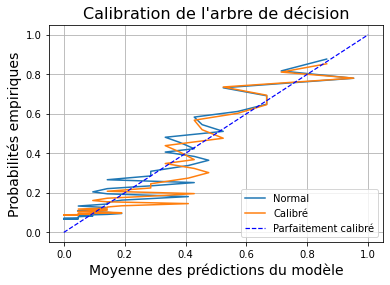

In [31]:
# Calibrate the best model with a sigmoïd 
best_model_calibrated = CalibratedClassifierCV(best_model, cv="prefit", method="sigmoid")
best_model_calibrated.fit(X_cal, y_cal)
# Prediction on calibration data
# With non calibrated model
y_pred_non_calib = best_model.predict_proba(X_cal)[:, 1]
# With calibrated model
y_pred_calib = best_model_calibrated.predict_proba(X_cal)[:, 1]

fractionsNorm, meansNorm = calibration_curve(y_cal, y_pred_non_calib, n_bins=50, strategy='quantile')
fractionsCal, meansCal = calibration_curve(y_cal, y_pred_calib, n_bins=50, strategy='quantile')

plt.figure()
plt.grid()
plt.plot(fractionsNorm, meansNorm, label="Normal", linewidth=1.5)
plt.plot(fractionsCal, meansCal, label="Calibré", linewidth=1.5)
plt.plot([0, 1], [0, 1], 'b--', label="Parfaitement calibré", linewidth=1.2)
plt.xlabel("Moyenne des prédictions du modèle", fontsize=14)
plt.ylabel("Probabilités empiriques", fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.title("Calibration de l'arbre de décision", fontsize=16)

#plt.savefig("figures/figure3.png")

plt.show()

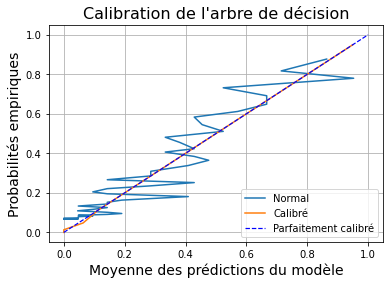

In [32]:
# Calibrate the best model with an Isotonic regression
best_model_calibrated = CalibratedClassifierCV(best_model, cv="prefit", method="isotonic")
best_model_calibrated.fit(X_cal, y_cal)
# Prediction on calibration data
# With non calibrated model
y_pred_non_calib = best_model.predict_proba(X_cal)[:, 1]
# With calibrated model
y_pred_calib = best_model_calibrated.predict_proba(X_cal)[:, 1]

fractionsNorm, meansNorm = calibration_curve(y_cal, y_pred_non_calib, n_bins=50, strategy='quantile')
fractionsCal, meansCal = calibration_curve(y_cal, y_pred_calib, n_bins=50, strategy='quantile')

plt.figure()
plt.grid()
plt.plot(fractionsNorm, meansNorm, label="Normal", linewidth=1.5)
plt.plot(fractionsCal, meansCal, label="Calibré", linewidth=1.5)
plt.plot([0, 1], [0, 1], 'b--', label="Parfaitement calibré", linewidth=1.2)
plt.xlabel("Moyenne des prédictions du modèle", fontsize=14)
plt.ylabel("Probabilités empiriques", fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.title("Calibration de l'arbre de décision", fontsize=16)

plt.show()

<div style="color: blue"> Conclusion: <div/>
<p style="color: black"> Le modèle de régression isotonic est le meilleur pour la calibration sur ce jeu de données. C'est lui que nous adopterons pour la suite.</p>

H - Importances des variables dans le modèle

In [33]:
importances_variables = best_model.feature_importances_
columns = config['data']['categorical']+config['data']['numerical']
paires_triees = sorted(zip(columns, importances_variables), key=lambda pair: pair[1],reverse=True)
colonnes_triees = []
importances_triees = []
for i, (var, imp) in enumerate(paires_triees):
    colonnes_triees.append(var)
    importances_triees.append(imp)
    print(i+1, ' - ', var, '----------> ', imp)

1  -  tenure ---------->  0.64041024
2  -  TechSupport ---------->  0.07971992
3  -  DeviceProtection ---------->  0.077660985
4  -  Contract ---------->  0.023851836
5  -  gender ---------->  0.017676292
6  -  MonthlyCharges ---------->  0.013563421
7  -  Partner ---------->  0.013349921
8  -  SeniorCitizen ---------->  0.012969003
9  -  PaymentMethod ---------->  0.012914848
10  -  OnlineSecurity ---------->  0.0121966405
11  -  OnlineBackup ---------->  0.011902323
12  -  StreamingTV ---------->  0.011673104
13  -  StreamingMovies ---------->  0.011314435
14  -  TotalCharges ---------->  0.010985297
15  -  PhoneService ---------->  0.010602764
16  -  PaperlessBilling ---------->  0.010241235
17  -  Dependents ---------->  0.009798247
18  -  MultipleLines ---------->  0.0097442595
19  -  InternetService ---------->  0.009425239


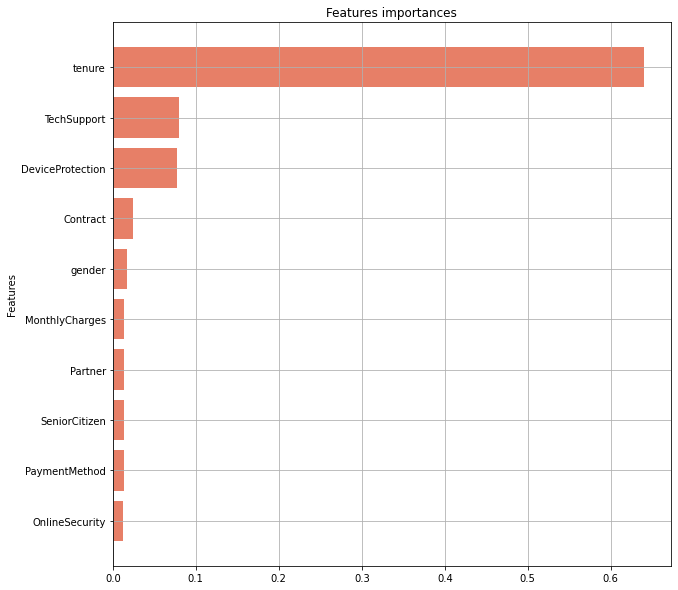

In [34]:
# Graphs
top = 10
plt.figure(figsize=(10, 10))
plt.grid()
plt.barh(colonnes_triees[0:top][::-1], importances_triees[0:top][::-1], color='#e77f67')
plt.title('Features importances')
plt.ylabel('Features')
plt.show('Importance in percentage (%) ')

In [35]:
def training_and_testing_pipeline(df, config,  n_trials):
    # Separate the dataset into train/test/calibration sets
    df_train, df_test = splitter(df,
                             config['data']['categorical'],
                             config['data']['numerical'], 
                             config['data']['label'],
                             seed=42,
                             percentage=config['model']['test_set_percentage'])

    df_test, df_cal = splitter(df_test,
                               config['data']['categorical'],
                               config['data']['numerical'], 
                               config['data']['label'],
                               seed=42,
                               percentage=config['model']['calibration_set_percentage'])
    # Preprocessing
    X, y = preprocessor(df_train, config, option_train='train', option_output='all')
    X_test, y_test = preprocessor(df_test, 
                                  config, 
                                  option_train='no-train', 
                                  option_output='all')
    
    X_cal, y_cal = preprocessor(df_cal, 
                                config, 
                                option_train='no-train', 
                                option_output='all')
    
    # Looking for best Hyper-parameters 
    study = optuna.create_study(direction="maximize")
    study.optimize(partial(objective, config=config, X=X, y=y), n_trials=n_trials)
    # Training the best model
    # Instanciation a model with the best hyperparameters
    best_model = XGBClassifier(random_state=config['seed'],
                               use_label_encoder=False,
                               eval_metric='auc',
                               **study.best_params)
    # Training on all the training set
    best_model.fit(X, y)
    # Calibrate the best model with an Isotonic regression
    best_model_calibrated = CalibratedClassifierCV(best_model, 
                                                   cv="prefit", 
                                                   method="isotonic")
    best_model_calibrated.fit(X_cal, y_cal)
    # Save the calibrated model
    model_name = config['model']['name']
    savepath = config['model']['savepath']
    savepath = os.path.join(savepath, model_name)
    with open(savepath, "wb") as file:
        pickle.dump(best_model_calibrated, file)
    print('The whole pipeline is over !')
    
    

In [36]:
%%time
training_and_testing_pipeline(df, config, n_trials=5)

======= L'encodage des variables catégorielles est terminée ! =======


[I 2022-06-16 13:49:59,846] A new study created in memory with name: no-name-01c9d71d-55dc-4b04-924d-af7764268f3e


======= L'encodage des variables catégorielles est terminée ! =======
======= L'encodage des variables catégorielles est terminée ! =======


[I 2022-06-16 13:50:01,568] Trial 0 finished with value: 0.6540355452219242 and parameters: {'n_estimators': 287, 'max_depth': 20, 'eta': 0.5699789185766228, 'subsample': 0.07354546342190005}. Best is trial 0 with value: 0.6540355452219242.
[I 2022-06-16 13:50:07,253] Trial 1 finished with value: 0.6788712011663469 and parameters: {'n_estimators': 346, 'max_depth': 20, 'eta': 0.9517768023763605, 'subsample': 0.6456301837160114}. Best is trial 1 with value: 0.6788712011663469.
[I 2022-06-16 13:50:09,388] Trial 2 finished with value: 0.6932813505944923 and parameters: {'n_estimators': 164, 'max_depth': 6, 'eta': 0.19798406426465853, 'subsample': 0.4769579686676372}. Best is trial 2 with value: 0.6932813505944923.
[I 2022-06-16 13:50:13,394] Trial 3 finished with value: 0.6796582191810764 and parameters: {'n_estimators': 271, 'max_depth': 20, 'eta': 0.5598471957771921, 'subsample': 0.38790918526731055}. Best is trial 2 with value: 0.6932813505944923.
[I 2022-06-16 13:50:14,228] Trial 4 fi

The whole pipeline is over !
CPU times: user 1min 35s, sys: 11.5 s, total: 1min 47s
Wall time: 14.9 s


In [ ]:
# First Partie: DATA SCIENCE

# Faire l'exploration des données
# Expliquer les différents modèles utilisés (arbre de décision, random forest, Gradient Boosting)
# Tester plusieurs algorithmes
# Choisir le meilleur et le rendre plus précis
# Calibrer le modèle final
# Afficher la matrice de confusion
# Sauvegarder le modèle
# Créer une fonction d'inférence

# Second Part: ML ENGINEER

# Create a flask endpoint for to serve the model
# Packager the model with Docker 
# Create an infra on GCP to deploy the model
# Deploy the model on GKE

# Test the code (Unit tests and Integration tests)
# Test the Api
# Test the data
# Create a CI/CD pipeline for the project with github actions
# Create a Makefile
# Create a logging system for the project
# Create a pre-commit hook
# Use arguments parser
# Create a readme for the project

# Third Part: WEB

# Develop a web interface to perform prediction on this for this project
# Connect to the back
